# Analyse Romy Events

In [2]:
import os
import obspy as obs
import matplotlib.pyplot as plt
import numpy as np

from obspy.clients.fdsn import Client

# from functions.request_data import __request_data
# from functions.compute_adr_pfo import __compute_adr_pfo
# from functions.compute_beamforming_pfo import __compute_beamforming_pfo

In [3]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

## Configurations

In [4]:
config = {}

## output path for figures
config['path_to_figs'] = data_path+"romy_events/figures/"

## path to data archive
config['path_to_data'] = data_path+"romy_events/data/"

## Event
config['tbeg'] = obs.UTCDateTime("2023-09-08 22:00")
config['tend'] = obs.UTCDateTime("2023-09-08 23:00")


config['event_name'] = "Marocco"

config['filename'] = f"ROMY_{config['event_name']}_{str(config['tbeg'].date).replace('-','')}_6C.mseed"

config['figname'] = f"ROMY_{config['event_name']}_{str(config['tbeg'].date).replace('-','')}"


## ROMY coordinates
config['ROMY_lon'] = 11.275501
config['ROMY_lat'] = 48.162941


config['fmin'] = 0.01
config['fmax'] = 0.5

In [5]:
!ls /home/andbro/kilauea-data/romy_events/data/

ROMY_Italy_20231025_6C.mseed
ROMY_Marocco_2023-09-08_6C.mseed
ROMY_Marocco_20230908_6C.mseed
ROMY_Mindanao_20231202_14:37:00_6C.mseed
ROMY_Mindanao2_20231202_16:03:00_6C.mseed
ROMY_Mindanao2_20231203_10:35:00_6C.mseed
ROMY_Morocco_20230908_6C.mseed


In [25]:
event = Client("USGS").get_events(starttime=config['tbeg'], endtime=config['tend'], minmagnitude=6.0)
event = event[0]
# print(event)

## Eventtime
config['eventtime'] = event.origins[0].time


from obspy.geodetics.base import gps2dist_azimuth

dist, az, baz = gps2dist_azimuth(event.origins[0].latitude, event.origins[0].longitude,
                                 config['ROMY_lat'], config['ROMY_lon'],
                                 )
dist/1000, az, baz

/tmp/ipykernel_284623/2208657696.py:11: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  dist, az, baz = gps2dist_azimuth(event.origins[0].latitude, event.origins[0].longitude,


(2526.012037508344, 35.64764658913597, 228.39689203768455)

## Load Data

In [112]:
st0 = obs.read(config['path_to_data']+config['filename'])
st0

6 Trace(s) in Stream:
BW.ROMY.10.BJZ | 2023-09-08T22:10:00.011600Z - 2023-09-08T23:00:00.011600Z | 20.0 Hz, 60001 samples
BW.ROMY..BJN   | 2023-09-08T22:09:59.999399Z - 2023-09-08T22:59:59.999399Z | 20.0 Hz, 60001 samples
BW.ROMY..BJE   | 2023-09-08T22:09:59.986601Z - 2023-09-08T22:59:59.986601Z | 20.0 Hz, 60001 samples
BW.DROMY..HHE  | 2023-09-08T22:10:00.000000Z - 2023-09-08T23:00:00.000000Z | 20.0 Hz, 60001 samples
BW.DROMY..HHN  | 2023-09-08T22:10:00.000000Z - 2023-09-08T23:00:00.000000Z | 20.0 Hz, 60001 samples
BW.DROMY..HHZ  | 2023-09-08T22:10:00.000000Z - 2023-09-08T23:00:00.000000Z | 20.0 Hz, 60001 samples

## Modify Data

In [141]:
acc = st0.select(station="DROMY").copy();
rot = st0.select(station="ROMY").copy();

fmin, fmax = 0.03, 0.2

rot.detrend("simple").taper(0.1).filter("bandpass", freqmin=fmin, freqmax=fmax);
acc.detrend("simple").taper(0.1).filter("bandpass", freqmin=fmin, freqmax=fmax);

acc.trim(config['tbeg']+850, config['tend']-1500)
rot.trim(config['tbeg']+850, config['tend']-1500)

3 Trace(s) in Stream:
BW.ROMY.10.BJZ | 2023-09-08T22:14:10.011600Z - 2023-09-08T22:35:00.011600Z | 20.0 Hz, 25001 samples
BW.ROMY..BJN   | 2023-09-08T22:14:09.999399Z - 2023-09-08T22:34:59.999399Z | 20.0 Hz, 25001 samples
BW.ROMY..BJE   | 2023-09-08T22:14:09.986601Z - 2023-09-08T22:34:59.986601Z | 20.0 Hz, 25001 samples

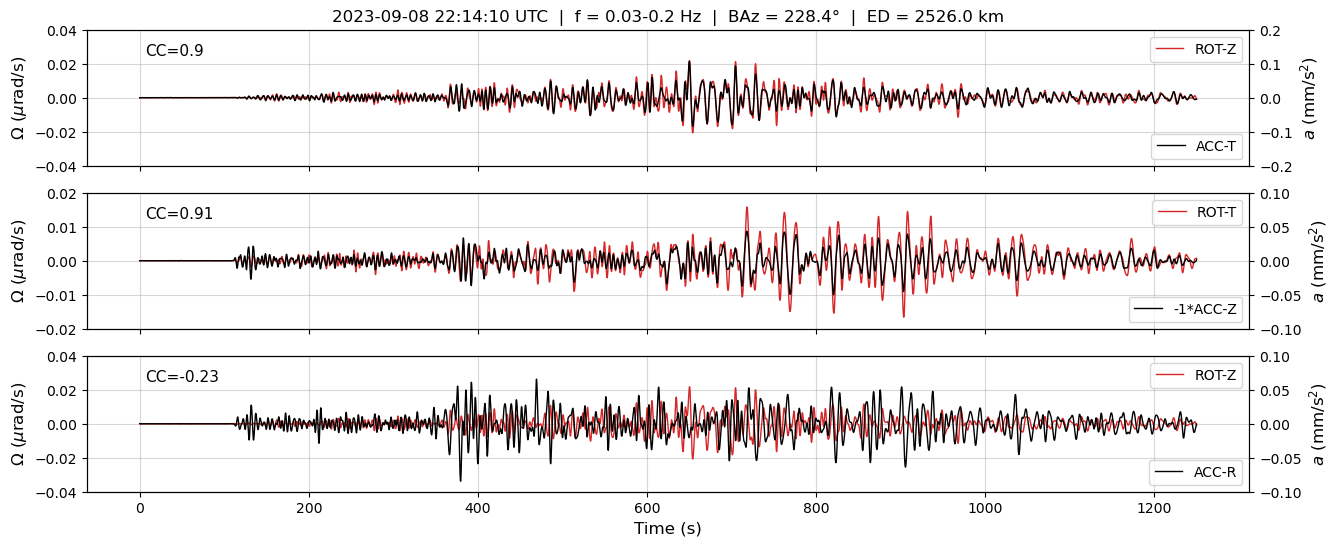

In [142]:
def __makeplot_waveform_comparison3(rot0, acc0, baz):

    from obspy.signal.cross_correlation import correlate
    from obspy.signal.rotate import rotate_ne_rt
    from numpy import linspace

    rot = rot0.copy()
    acc = acc0.copy()

    fig, ax = plt.subplots(3, 1, figsize=(15, 6), sharex=True)

    acc_scaling, acc_unit = 1e3, f"mm/s$^2$"
    rot_scaling, rot_unit = 1e6, f"$\mu$rad/s"

    lw = 1

    font = 12

    acc_z = acc.select(channel="*Z")[0].data
    rot_z = rot.select(channel="*Z")[0].data

    acc_r, acc_t = rotate_ne_rt(acc.select(channel="*N")[0].data, acc.select(channel="*E")[0].data, baz)
    rot_r, rot_t = rotate_ne_rt(rot.select(channel="*N")[0].data, rot.select(channel="*E")[0].data, baz)

    rot_z*=rot_scaling
    rot_r*=rot_scaling
    rot_t*=rot_scaling

    acc_z*=acc_scaling
    acc_r*=acc_scaling
    acc_t*=acc_scaling

    acc_z_max = max([abs(min(acc_z)), abs(max(acc_z))])
    acc_r_max = max([abs(min(acc_r)), abs(max(acc_r))])
    acc_t_max = max([abs(min(acc_t)), abs(max(acc_t))])

    rot_z_max = max([abs(min(rot_z)), abs(max(rot_z))])
    rot_r_max = max([abs(min(rot_r)), abs(max(rot_r))])
    rot_t_max = max([abs(min(rot_t)), abs(max(rot_t))])


    ax[0].plot(rot.select(channel="*Z")[0].times(), rot_z, label="ROT-Z", color="tab:red", lw=lw, zorder=3)
    ax00 = ax[0].twinx()
    ax00.plot(acc.select(channel="*Z")[0].times(), acc_t, label="ACC-T", color="black", lw=lw)

    ax[0].set_ylim(-rot_z_max, rot_z_max)
    ax00.set_ylim(-acc_t_max, acc_t_max)

    ax[1].plot(rot.select(channel="*N")[0].times(), rot_t, label="ROT-T", color="tab:red", lw=lw, zorder=3)
    ax11 = ax[1].twinx()
    ax11.plot(acc.select(channel="*Z")[0].times(), -acc_z, label="-1*ACC-Z", color="black", lw=lw)

    ax[1].set_ylim(-rot_t_max, rot_t_max)
    ax11.set_ylim(-acc_z_max, acc_z_max)

    ax[2].plot(rot.select(channel="*N")[0].times(), rot_z, label="ROT-Z", color="tab:red", lw=lw, zorder=3)
    ax22 = ax[2].twinx()
    ax22.plot(acc.select(channel="*Z")[0].times(), acc_r, label="ACC-R", color="black", lw=lw)

    ax[2].set_ylim(-rot_z_max, rot_z_max)
    ax22.set_ylim(-acc_r_max, acc_r_max)

    cc1 = round(correlate(rot_z, acc_t, 0, demean=True, normalize='naive', method='auto')[0], 2)
    cc2 = round(correlate(rot_t, -acc_z, 0, demean=True, normalize='naive', method='auto')[0], 2)
    cc3 = round(correlate(rot_z, acc_r, 0, demean=True, normalize='naive', method='auto')[0], 2)
    cc = [cc1, cc2, cc3]

    ## sync twinx
    ax[0].set_yticks(linspace(ax[0].get_yticks()[0], ax[0].get_yticks()[-1], len(ax[0].get_yticks())))
    ax00.set_yticks(linspace(ax00.get_yticks()[0], ax00.get_yticks()[-1], len(ax[0].get_yticks())))

    ax[1].set_yticks(linspace(ax[1].get_yticks()[0], ax[1].get_yticks()[-1], len(ax[1].get_yticks())))
    ax11.set_yticks(linspace(ax11.get_yticks()[0], ax11.get_yticks()[-1], len(ax[1].get_yticks())))

    ax[2].set_yticks(linspace(ax[2].get_yticks()[0], ax[2].get_yticks()[-1], len(ax[2].get_yticks())))
    ax22.set_yticks(linspace(ax22.get_yticks()[0], ax22.get_yticks()[-1], len(ax[2].get_yticks())))

    for i in range(3):
        ax[i].legend(loc=1, ncols=4)
        ax[i].grid(which="both", alpha=0.5)
        ax[i].set_ylabel(f"$\Omega$ ({rot_unit})", fontsize=font)
        ax[i].text(0.05, 0.9, f"CC={cc[i]}", ha='left', va='top', transform=ax[i].transAxes, fontsize=font-1)

    for _ax in [ax00, ax11, ax22]:
        _ax.legend(loc=4)
        _ax.set_ylabel(f"$a$ ({acc_unit})", fontsize=font)

    ax[2].set_xlabel("Time (s)", fontsize=font)

    tbeg = acc[0].stats.starttime
    ax[0].set_title(f"{tbeg.date} {str(tbeg.time).split('.')[0]} UTC  |  f = {fmin}-{fmax} Hz  |  BAz = {round(baz, 1)}°  |  ED = {round(dist/1000,1)} km")


    plt.show();
    return fig

fig = __makeplot_waveform_comparison3(rot, acc, baz)


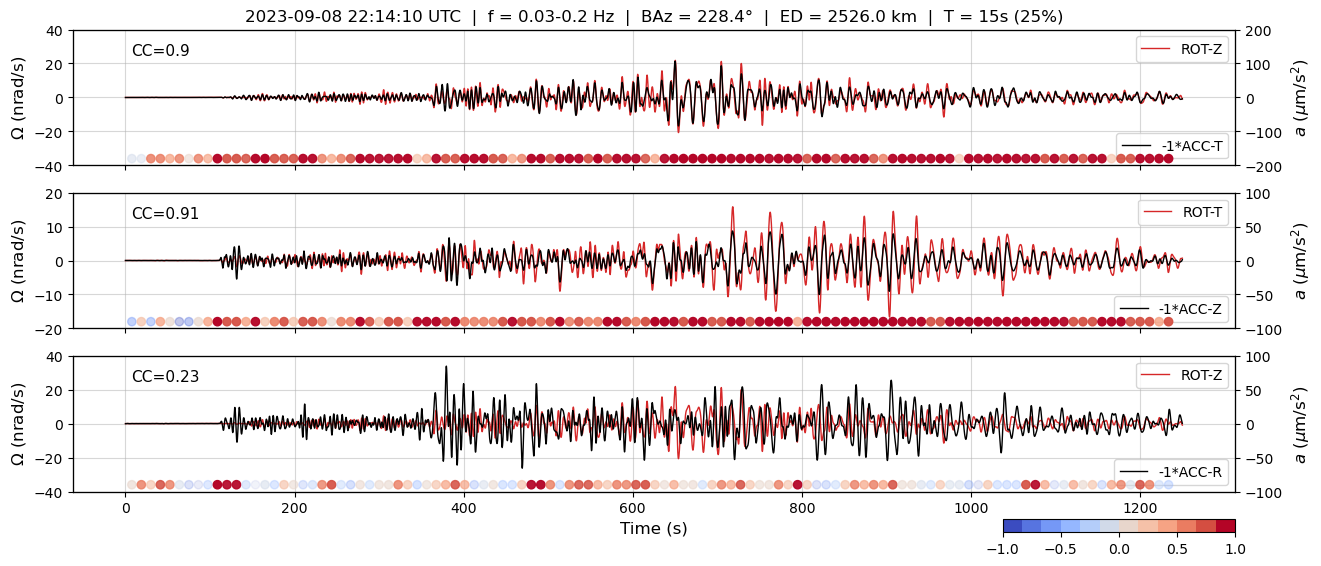

In [236]:
def __makeplot_waveform_comparison_cc(rot0, acc0, baz, twin_sec=5, twin_overlap=0.5):

    from obspy.signal.cross_correlation import correlate
    from obspy.signal.rotate import rotate_ne_rt
    from numpy import linspace

    def __cross_correlation_windows(arr1, arr2, dt, Twin, overlap=0, lag=0, demean=True, plot=False):

        from obspy.signal.cross_correlation import correlate, xcorr_max
        from numpy import arange, array, roll

        N = len(arr1)
        n_interval = int(Twin/dt)
        n_overlap = int(overlap*Twin/dt)

        # time = arange(0, N*dt, dt)

        times, samples = [], []
        n1, n2 = 0, n_interval
        while n2 <= N:
            samples.append((n1, n2))
            times.append(int(n1+(n2-n1)/2)*dt)
            n1 = n1 + n_interval - n_overlap
            n2 = n2 + n_interval - n_overlap

        cc = []
        for _n, (n1, n2) in enumerate(samples):

            _arr1 = roll(arr1[n1:n2], lag)
            _arr2 = arr2[n1:n2]
            ccf = correlate(_arr1, _arr2, 0, demean=demean, normalize='naive', method='fft')
            shift, val = xcorr_max(ccf)
            cc.append(val)

        return array(times), array(cc)


    rot = rot0.copy()
    acc = acc0.copy()

    Nrow, Ncol = 3, 1

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 6), sharex=True)

    acc_scaling, acc_unit = 1e6, f"$\mu$m/s$^2$"
    rot_scaling, rot_unit = 1e9, f"nrad/s"

    lw = 1

    font = 12

    acc_z = acc.select(channel="*Z")[0].data
    rot_z = rot.select(channel="*Z")[0].data

    acc_r, acc_t = rotate_ne_rt(acc.select(channel="*N")[0].data, acc.select(channel="*E")[0].data, baz)
    rot_r, rot_t = rotate_ne_rt(rot.select(channel="*N")[0].data, rot.select(channel="*E")[0].data, baz)

    rot_z*=rot_scaling
    rot_r*=rot_scaling
    rot_t*=rot_scaling

    acc_z*=acc_scaling
    acc_r*=acc_scaling
    acc_t*=acc_scaling

    acc_z_max = max([abs(min(acc_z)), abs(max(acc_z))])
    acc_r_max = max([abs(min(acc_r)), abs(max(acc_r))])
    acc_t_max = max([abs(min(acc_t)), abs(max(acc_t))])

    rot_z_max = max([abs(min(rot_z)), abs(max(rot_z))])
    rot_r_max = max([abs(min(rot_r)), abs(max(rot_r))])
    rot_t_max = max([abs(min(rot_t)), abs(max(rot_t))])

    dt = rot[0].stats.delta


    tt0, cc0 = __cross_correlation_windows(rot_z, acc_t, dt, twin_sec, overlap=twin_overlap, lag=0, demean=True)
    tt1, cc1 = __cross_correlation_windows(rot_t, -acc_z, dt, twin_sec, overlap=twin_overlap, lag=0, demean=True)
    tt2, cc2 = __cross_correlation_windows(rot_z, -acc_r, dt, twin_sec, overlap=twin_overlap, lag=0, demean=True)

    cmap = plt.get_cmap("coolwarm", 12)


    ax[0].plot(rot.select(channel="*Z")[0].times(), rot_z, label="ROT-Z", color="tab:red", lw=lw, zorder=3)
    ax00 = ax[0].twinx()
    ax00.plot(acc.select(channel="*Z")[0].times(), acc_t, label="-1*ACC-T", color="black", lw=lw)
    ax01 = ax[0].twinx()
    cm = ax01.scatter(tt0, np.ones(len(tt0))*-0.9, c=cc0, alpha=(cc0+1)/2, cmap=cmap, label="")

    ax[0].set_ylim(-rot_z_max, rot_z_max)
    ax00.set_ylim(-acc_t_max, acc_t_max)
    ax01.set_ylim(-1, 1)
    ax01.yaxis.set_visible(False)

    ax[1].plot(rot.select(channel="*N")[0].times(), rot_t, label="ROT-T", color="tab:red", lw=lw, zorder=3)
    ax11 = ax[1].twinx()
    ax11.plot(acc.select(channel="*Z")[0].times(), -acc_z, label="-1*ACC-Z", color="black", lw=lw)
    ax12 = ax[1].twinx()
    ax12.scatter(tt1, np.ones(len(tt1))*-0.9, c=cc1, alpha=(cc1+1)/2, cmap=cmap, label="")

    ax[1].set_ylim(-rot_t_max, rot_t_max)
    ax11.set_ylim(-acc_z_max, acc_z_max)
    ax12.set_ylim(-1, 1)
    ax12.yaxis.set_visible(False)

    ax[2].plot(rot.select(channel="*N")[0].times(), rot_z, label="ROT-Z", color="tab:red", lw=lw, zorder=3)
    ax22 = ax[2].twinx()
    ax22.plot(acc.select(channel="*Z")[0].times(), -acc_r, label="-1*ACC-R", color="black", lw=lw)
    ax23 = ax[2].twinx()
    ax23.scatter(tt2, np.ones(len(tt2))*-0.9, c=cc2, alpha=(cc2+1)/2, cmap=cmap, label="")

    ax[2].set_ylim(-rot_z_max, rot_z_max)
    ax22.set_ylim(-acc_r_max, acc_r_max)
    ax23.set_ylim(-1, 1)
    ax23.yaxis.set_visible(False)

    cc1 = round(correlate(rot_z, acc_t, 0, demean=True, normalize='naive', method='auto')[0], 2)
    cc2 = round(correlate(rot_t, -acc_z, 0, demean=True, normalize='naive', method='auto')[0], 2)
    cc3 = round(correlate(rot_z, -acc_r, 0, demean=True, normalize='naive', method='auto')[0], 2)
    cc = [cc1, cc2, cc3]

    ## sync twinx
    ax[0].set_yticks(linspace(ax[0].get_yticks()[0], ax[0].get_yticks()[-1], len(ax[0].get_yticks())))
    ax00.set_yticks(linspace(ax00.get_yticks()[0], ax00.get_yticks()[-1], len(ax[0].get_yticks())))

    ax[1].set_yticks(linspace(ax[1].get_yticks()[0], ax[1].get_yticks()[-1], len(ax[1].get_yticks())))
    ax11.set_yticks(linspace(ax11.get_yticks()[0], ax11.get_yticks()[-1], len(ax[1].get_yticks())))

    ax[2].set_yticks(linspace(ax[2].get_yticks()[0], ax[2].get_yticks()[-1], len(ax[2].get_yticks())))
    ax22.set_yticks(linspace(ax22.get_yticks()[0], ax22.get_yticks()[-1], len(ax[2].get_yticks())))
    for i in range(3):
        ax[i].legend(loc=1, ncols=4)
        ax[i].grid(which="both", alpha=0.5)
        ax[i].set_ylabel(f"$\Omega$ ({rot_unit})", fontsize=font)
        ax[i].text(0.05, 0.9, f"CC={cc[i]}", ha='left', va='top', transform=ax[i].transAxes, fontsize=font-1)

    for _ax in [ax00, ax11, ax22]:
        _ax.legend(loc=4)
        _ax.set_ylabel(f"$a$ ({acc_unit})", fontsize=font)

    ax[2].set_xlabel("Time (s)", fontsize=font)

    tbeg = acc[0].stats.starttime
    ax[0].set_title(f"{tbeg.date} {str(tbeg.time).split('.')[0]} UTC  |  f = {fmin}-{fmax} Hz  |  BAz = {round(baz, 1)}°  |  ED = {round(dist/1000,1)} km  |  T = {twin_sec}s ({int(100*twin_overlap)}%)")

    cax = ax[Nrow-1].inset_axes([0.8, -0.3, 0.2, 0.1], transform=ax[Nrow-1].transAxes)
    cb = plt.colorbar(cm, cax=cax, shrink=0.4, location='bottom', orientation='horizontal')
    cm.set_clim(-1, 1)

    plt.show();
    return fig


fig = __makeplot_waveform_comparison_cc(rot, acc, baz, twin_sec=15, twin_overlap=0.25)


In [279]:
from functions.makeplot_comparison_ccf import __makeplot_comparison_ccf

In [280]:
fig = __makeplot_comparison_ccf(rot, acc, baz, twin_sec=15, twin_overlap=0.25, fmin=None, fmax=None)

TypeError: __makeplot_comparison_ccf() got an unexpected keyword argument 'fmin'

### Compare ADR and ROMY

In [238]:
def __makeplot_waveform_comparison_all(st_in):

    from obspy.signal.cross_correlation import correlate

    st = st_in.copy()

    # st = st.trim(st[0].stats.starttime+5, st[0].stats.endtime-15).copy()

    fig, ax = plt.subplots(9, 1, figsize=(15, 15), sharex=True)

    lw = 1.2

    font = 12

    fband = [(1.0, 6.0), (0.5, 1.0), (0.1, 0.5)]

    offset = [0, 0, 0]

    plt.subplots_adjust(hspace=0.05)

    scaling = 1e6

    idx = 0
    for _m, array in enumerate(["in", "mi", "al"]):

        _adr = st.select(location=array).copy()
        _bspf = st.select(station="BSPF").copy()

        _bspf = _bspf.detrend("simple").taper(0.1).filter("bandpass", freqmin=fband[_m][0], freqmax=fband[_m][1], corners=4, zerophase=True)
        _adr = _adr.detrend("simple").taper(0.1).filter("bandpass", freqmin=fband[_m][0], freqmax=fband[_m][1], corners=4, zerophase=True)

        for _k, comp in enumerate(["Z", "N", "E"]):

            ax[idx].plot(_bspf.select(channel=f"*{comp}")[0].times(), _bspf.select(channel=f"*{comp}")[0].data*scaling, label=f"BSPF-{comp}", color="k", lw=lw)
            ax[idx].plot(_adr.select(channel=f"*{comp}")[0].times(), _adr.select(channel=f"*{comp}")[0].data*scaling, label=f"{array[0]}ADR-{comp}", color="r", lw=lw)

            cc = round(correlate(_bspf.select(channel=f"*{comp}")[0].data, _adr.select(channel=f"*{comp}")[0].data, 0, demean=True, normalize='naive', method='auto')[0], 2)

            rmse = np.round( np.sqrt( np.mean( ( ( _adr.select(channel=f"*{comp}")[0].data -_bspf.select(channel=f"*{comp}")[0].data )*scaling )**2 ) ), 3)

            ax[idx].text(0.01, 0.9, f"{fband[_m][0]}-{fband[_m][1]} Hz", ha='left', va='top', transform=ax[idx].transAxes, fontsize=font-2)
            ax[idx].text(0.08, 0.9, f"CC={cc}", ha='left', va='top', transform=ax[idx].transAxes, fontsize=font-2)
            # ax[idx].text(0.15, 0.9, f"RMSE={rmse}", ha='left', va='top', transform=ax[idx].transAxes, fontsize=font-2)

            ax[idx].legend(loc=1, ncols=4, fontsize=font-2)

            # ax[idx].grid(which="both", alpha=0.5)

            ax[idx].set_ylabel("$\Omega$ ($\mu$rad/s)", fontsize=font)

            if idx < 8:
                ax[idx].tick_params(axis='x', bottom=False)

            for pos in ["right", "top", "bottom"]:
                ax[idx].spines[pos].set_visible(False)

            idx += 1

    ax[idx-1].spines["bottom"].set_visible(True)

    ax[idx-1].set_xlabel(f"Time (s) from {config['tbeg'].date} {str(config['tbeg'].time).split('.')[0]} UTC", fontsize=font)

    # ax[0].set_title(f"{config['tbeg'].date} | {config['fmin']}-{config['fmax']} Hz | ADR {submask} | CC$_Z$ = {cc_Z} | CC$_N$ = {cc_N} | CC$_E$ = {cc_E}")

    plt.show();
    return fig

In [241]:
def __makeplot_spectra_comparison1(st_rot, st_acc, fmin=None, fmax=None, ylog=False, xlog=False, fill=False):

    def __multitaper_psd(arr, dt, n_win=5, time_bandwidth=4.0):

        import multitaper as mt

        out_psd = mt.MTSpec(arr, nw=time_bandwidth, kspec=n_win, dt=dt, iadapt=2)

        _f, _psd = out_psd.rspec()

        f = _f.reshape(_f.size)
        psd = _psd.reshape(_psd.size)

        ## 95% confidence interval
        # _psd95 = out_psd.jackspec()
        # psd95_lower, psd95_upper = psd95[::2, 0], psd95[::2, 1]

        return f, psd

    Tsec = 5
    f1_Z, psd1_Z = __multitaper_psd(st_rot.select(channel="*Z")[0].data, st_rot[0].stats.delta ,n_win=Tsec)
    f2_Z, psd2_Z = __multitaper_psd(st_acc.select(channel="*Z")[0].data, st_acc[0].stats.delta ,n_win=Tsec)

    f1_U, psd1_U = __multitaper_psd(st_rot.select(channel="*N")[0].data, st_rot[0].stats.delta ,n_win=Tsec)
    f2_N, psd2_N = __multitaper_psd(st_acc.select(channel="*N")[0].data, st_acc[0].stats.delta ,n_win=Tsec)

    f1_V, psd1_V = __multitaper_psd(st_rot.select(channel="*E")[0].data, st_rot[0].stats.delta ,n_win=Tsec)
    f2_E, psd2_E = __multitaper_psd(st_acc.select(channel="*E")[0].data, st_acc[0].stats.delta ,n_win=Tsec)


    Nrow, Ncol = 1, 3

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    plt.subplots_adjust(wspace=0.2)

    font = 14

    rot_scaling = 1e9

    lw = 1

    if fill:

        ax[0].fill_between(f1_Z, psd1_Z, lw=lw, label=f"{st_rot[0].stats.station}.{st_rot[0].stats.channel}", color="darkred", alpha=0.5, zorder=3)
        ax00 = ax[0].twinx()
        ax00.fill_between(f2_Z, psd2_Z, lw=lw, label=f"{st_acc[0].stats.station}.{st_acc[0].stats.channel}", color="black", alpha=0.5, zorder=2)

        ax[1].fill_between(f1_U, psd1_U, lw=lw, label=f"{st_rot[1].stats.station}.{st_rot[1].stats.channel}", color="darkred", alpha=0.5, zorder=3)
        ax11 = ax[1].twinx()
        ax11.fill_between(f2_N, psd2_N, lw=lw, label=f"{st_acc[1].stats.station}.{st_acc[1].stats.channel}", color="black", alpha=0.5, zorder=2)

        ax[2].fill_between(f1_V, psd1_V, lw=lw, label=f"{st_rot[2].stats.station}.{st_rot[2].stats.channel}", color="darkred", alpha=0.5, zorder=3)
        ax22 = ax[2].twinx()
        ax22.fill_between(f2_E, psd2_E, lw=lw, label=f"{st_acc[2].stats.station}.{st_acc[2].stats.channel}", color="black", alpha=0.5, zorder=2)

    else:
        ax[0].plot(f1_Z, psd1_Z, lw=lw, label=f"{st_rot[0].stats.station}.{st_rot[0].stats.channel}", color="darkred", ls="-", zorder=3)

        ax00 = ax[0].twinx()
        ax00.plot(f2_Z, psd2_Z, lw=lw, label=f"{st_acc[0].stats.station}.{st_acc[0].stats.channel}", color="black", zorder=2)

        ax[1].plot(f1_U, psd1_U, lw=lw, label=f"{st_rot[1].stats.station}.{st_rot[1].stats.channel}", color="darkred", ls="-", zorder=3)
        ax11 = ax[1].twinx()
        ax11.plot(f2_N, psd2_N, lw=lw, label=f"{st_acc[1].stats.station}.{st_acc[1].stats.channel}", color="black", zorder=2)

        ax[2].plot(f1_V, psd1_V, lw=lw, label=f"{st_rot[2].stats.station}.{st_rot[2].stats.channel}", color="darkred", ls="-", zorder=3)
        ax22 = ax[2].twinx()
        ax22.plot(f2_E, psd2_E, lw=lw, label=f"{st_acc[2].stats.station}.{st_acc[2].stats.channel}", color="black", zorder=2)


#     ax[0].set_ylim(0, max(psd1_Z)+0.1*max(psd1_Z))
#     ax[1].set_ylim(0, max(psd1_U)+0.1*max(psd1_U))
#     ax[2].set_ylim(0, max(psd1_V)+0.1*max(psd1_V))

#     ax00.set_yticks(np.linspace(ax00.get_yticks()[0], ax00.get_yticks()[-1], len(ax[0].get_yticks())))
#     ax11.set_yticks(np.linspace(ax11.get_yticks()[0], ax11.get_yticks()[-1], len(ax[1].get_yticks())))
#     ax22.set_yticks(np.linspace(ax22.get_yticks()[0], ax22.get_yticks()[-1], len(ax[2].get_yticks())))

    for i in range(3):
        ax[i].legend(loc=1, ncols=4)
        if xlog:
            ax[i].set_xscale("log")
        if ylog:
            ax[i].set_yscale("log")
        ax[i].grid(which="both", alpha=0.5)
        ax[i].tick_params(axis='y', colors='darkred')
        ax[i].set_xlabel("Frequency (Hz)")
        ax[i].set_ylim(bottom=0)

        if fmin:
            ax[i].set_xlim(left=fmin)
        if fmax:
            ax[i].set_xlim(right=fmax)
        else:
            ax[i].set_xlim(right=st_rot[0].stats.sampling_rate*0.5)

    for _ax in [ax00, ax11, ax22]:
        _ax.set_xlim(2e-2, 2e1)
        _ax.legend(loc=2)
        _ax.set_ylim(bottom=0)

        if ylog:
            _ax.set_yscale("log")
        if fmin:
            _ax.set_xlim(left=fmin)
        if fmax:
            _ax.set_xlim(right=fmax)
        else:
            _ax.set_xlim(right=st_rot[0].stats.sampling_rate*0.5)

    ax[0].set_ylabel(r"PSD (rad$^2$/s$^2$/Hz)", color="darkred")
    ax22.set_ylabel(r"PSD (m$^2$/s$^4$/Hz)")

    # ax[2].set_xlabel("Frequency (Hz)")
    # ax[0].set_title(f"{config['tbeg'].date} {str(config['tbeg'].time).split('.')[0]} UTC | {config['fmin']}-{config['fmax']} Hz ")

    plt.show();
    return fig

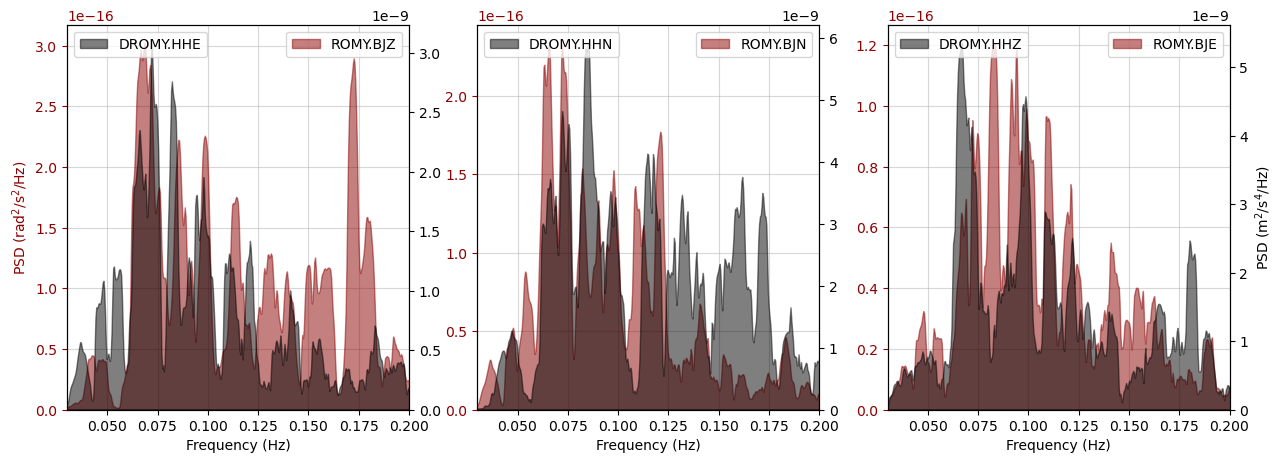

In [242]:

fig = __makeplot_spectra_comparison1(rot, acc, fmin=fmin, fmax=fmax, ylog=False, xlog=False, fill=True)

fig.savefig(config['path_to_figs']+f"{config['figname']}_spectra_all2.png", format="png", dpi=150, bbox_inches='tight');


In [145]:
def __makeplot_spectra_comparison2(st_rot, st_acc, fmin=None, fmax=None, xlog=False, ylog=False):

    def __multitaper_psd(arr, dt, n_win=5, time_bandwidth=4.0):

        import multitaper as mt

        out_psd = mt.MTSpec(arr, nw=time_bandwidth, kspec=n_win, dt=dt, iadapt=0)

        _f, _psd = out_psd.rspec()

        f = _f.reshape(_f.size)
        psd = _psd.reshape(_psd.size)

        ## 95% confidence interval
        # _psd95 = out_psd.jackspec()
        # psd95_lower, psd95_upper = psd95[::2, 0], psd95[::2, 1]

        return f, psd

    Tsec = 5
    f1_Z, psd1_Z = __multitaper_psd(st_rot.select(channel="*Z")[0].data, st_rot[0].stats.delta ,n_win=Tsec)
    f2_Z, psd2_Z = __multitaper_psd(st_acc.select(channel="*Z")[0].data, st_acc[0].stats.delta ,n_win=Tsec)

    f1_U, psd1_U = __multitaper_psd(st_rot.select(channel="*N")[0].data, st_rot[0].stats.delta ,n_win=Tsec)
    f2_N, psd2_N = __multitaper_psd(st_acc.select(channel="*N")[0].data, st_acc[0].stats.delta ,n_win=Tsec)

    f1_V, psd1_V = __multitaper_psd(st_rot.select(channel="*E")[0].data, st_rot[0].stats.delta ,n_win=Tsec)
    f2_E, psd2_E = __multitaper_psd(st_acc.select(channel="*E")[0].data, st_acc[0].stats.delta ,n_win=Tsec)


    fig, ax = plt.subplots(3, 1, figsize=(15, 5), sharex=True)

    font = 14

    rot_scaling = 1e9

    lw = 1

    ax[0].plot(f1_Z, psd1_Z, lw=lw, label=f"{st_rot[0].stats.station}.{st_rot[0].stats.channel}", color="darkred", ls="-", zorder=3)

    ax00 = ax[0].twinx()
    ax00.plot(f2_Z, psd2_Z, lw=lw, label=f"{st_acc[0].stats.station}.{st_acc[0].stats.channel}", color="black", zorder=2)

    ax[1].plot(f1_U, psd1_U, lw=lw, label=f"{st_rot[1].stats.station}.{st_rot[1].stats.channel}", color="darkred", ls="-", zorder=3)
    ax11 = ax[1].twinx()
    ax11.plot(f2_N, psd2_N, lw=lw, label=f"{st_acc[1].stats.station}.{st_acc[1].stats.channel}", color="black", zorder=2)

    ax[2].plot(f1_V, psd1_V, lw=lw, label=f"{st_rot[2].stats.station}.{st_rot[2].stats.channel}", color="darkred", ls="-", zorder=3)
    ax22 = ax[2].twinx()
    ax22.plot(f2_E, psd2_E, lw=lw, label=f"{st_acc[2].stats.station}.{st_acc[2].stats.channel}", color="black", zorder=2)


    for i in range(3):
        ax[i].legend(loc=1, ncols=4)
        if xlog:
            ax[i].set_xscale("log")
        if ylog:
            ax[i].set_yscale("log")

        ax[i].grid(which="both", alpha=0.5)
        ax[i].set_ylabel(r"PSD (rad$^2$/s$^2$/Hz)", color="darkred")
        ax[i].tick_params(axis='y', colors='darkred')

        if fmin:
            ax[i].set_xlim(left=fmin)
        if fmax:
            ax[i].set_xlim(right=fmax)
        else:
            ax[i].set_xlim(right=st_rot[0].stats.sampling_rate*0.5)

    for _ax in [ax00, ax11, ax22]:
        if ylog:
            _ax.set_yscale("log")
        _ax.set_xlim(2e-2, 2e1)
        _ax.set_ylabel(r"PSD (m$^2$/s$^4$/Hz)")
        _ax.legend(loc=4)

        if fmin:
            _ax.set_xlim(left=fmin)
        if fmax:
            _ax.set_xlim(right=fmax)
        else:
            _ax.set_xlim(right=st_rot[0].stats.sampling_rate*0.5)

    ax[2].set_xlabel("Frequency (Hz)")
    # ax[0].set_title(f"{config['tbeg'].date} {str(config['tbeg'].time).split('.')[0]} UTC | {config['fmin']}-{config['fmax']} Hz ")

    plt.show();
    return fig

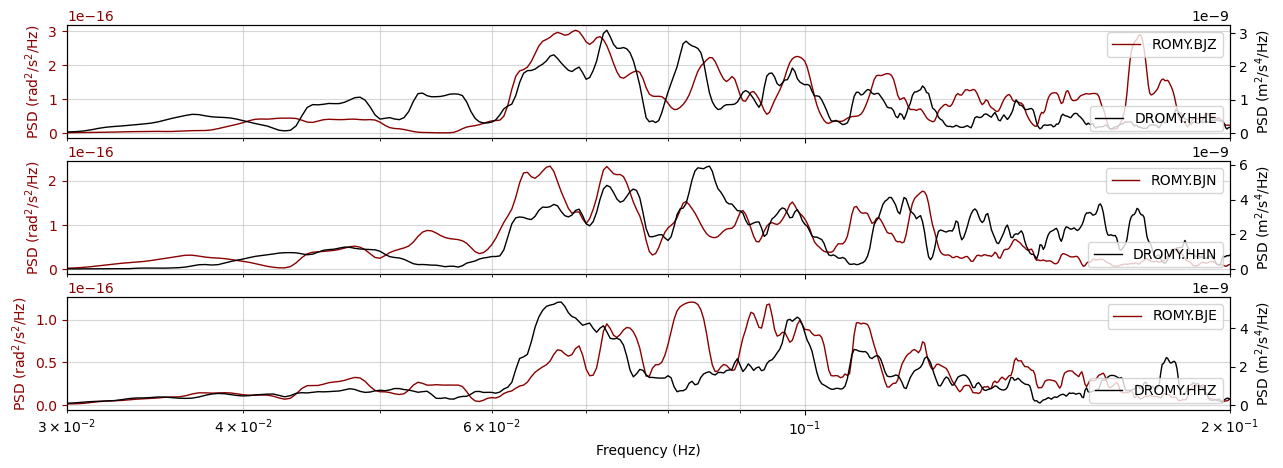

In [146]:
fig = __makeplot_spectra_comparison2(rot, acc, fmin=fmin, fmax=fmax, xlog=True, ylog=False)

fig.savefig(config['path_to_figs']+f"{config['figname']}_spectra_all2.png", format="png", dpi=150, bbox_inches='tight');


## Backazimuth

In [122]:
from functions.compute_backazimuth import __compute_backazimuth

In [123]:
from functions.get_theoretical_backazimuth import __get_theoretical_backazimuth

In [124]:
from functions.compute_backazimuth_tangent import __compute_backazimuth_tangent

In [125]:
config['event'] = event

baz, az, dist = __get_theoretical_backazimuth(config['ROMY_lat'], config['ROMY_lon'], event_obj=event, fdsn_client='USGS')

In [126]:

# acc.select(channel="*Z")[0].data *= -1
# rot.select(channel="*Z")[0].data *= -1
# rot.select(channel="*E")[0].data *= -1
# rot.select(channel="*N")[0].data *= -1

In [127]:
config['station_longitude'] = config['ROMY_lon']
config['station_latitude']  = config['ROMY_lat']

## specify window length for baz estimation in seconds
config['win_length_sec'] = 2/fmin

## define an overlap for the windows in percent (50 -> 50%)
config['overlap'] = 50

## specify steps for degrees of baz
config['step'] = 1

config['eventtime'] = event.origins[0].time


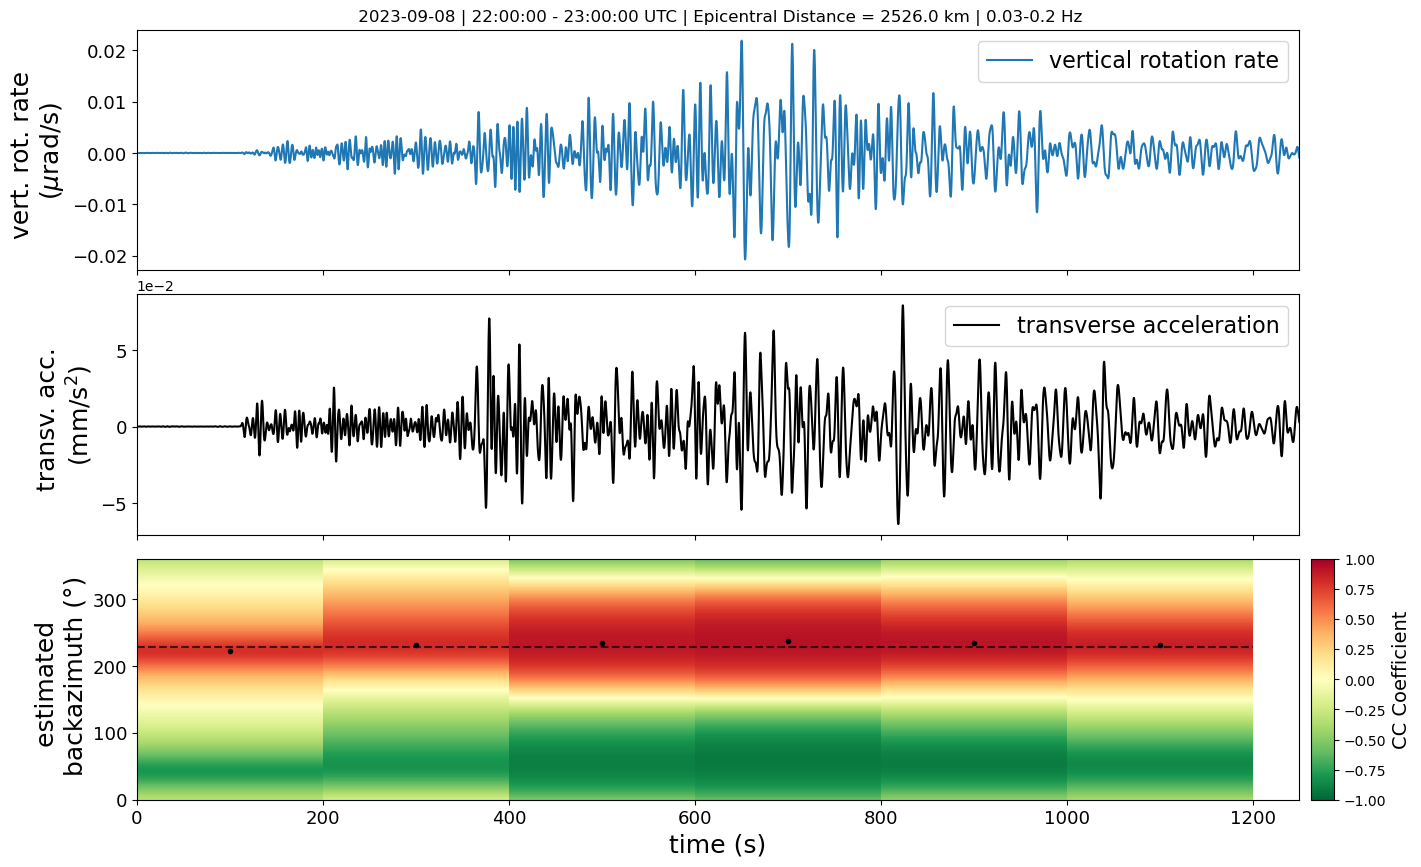

228.39689203768455


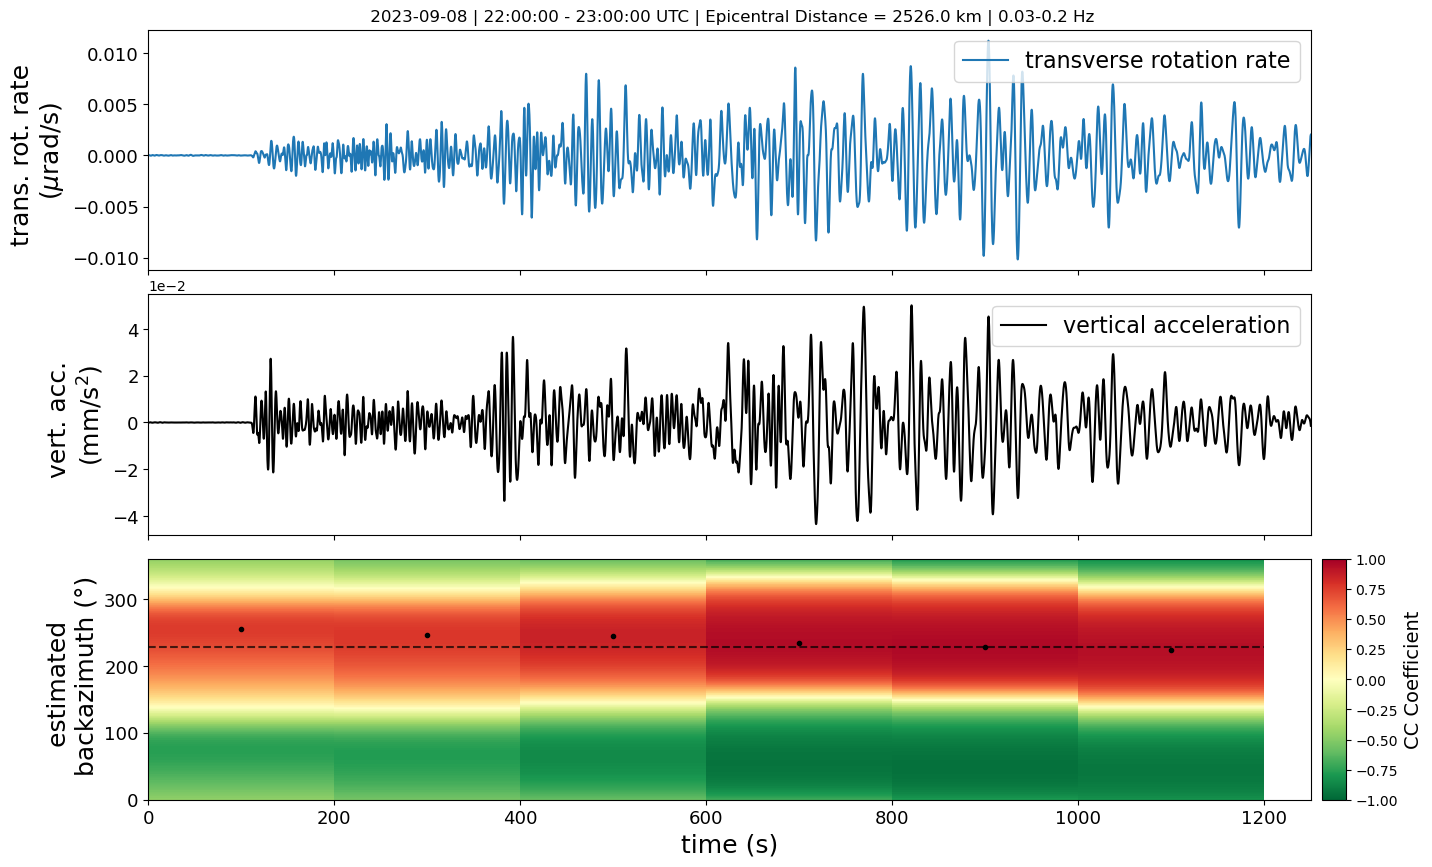

228.39689203768455


In [260]:
out = __compute_backazimuth(
                            acc,
                            rot,
                            config,
                            wave_type='love',
                            event=event,
                            plot=True,
                            flim=(fmin, fmax),
                            show_details=False,
)

# out['fig'].savefig(config['path_to_figs']+f"{config['figname']}_baz_love_{fmin}_{fmax}.png", dpi=150, bbox_inches='tight', pad_inches=0.05)
print(out['baz_theo'])

out = __compute_backazimuth(
                            acc,
                            rot,
                            config,
                            wave_type='rayleigh',
                            event=event,
                            plot=True,
                            flim=(fmin, fmax),
                            show_details=False,
)

# out['fig'].savefig(config['path_to_figs']+f"{config['figname']}_rayleigh_{fmin}_{fmax}.png", dpi=150, bbox_inches='tight', pad_inches=0.05)
print(out['baz_theo'])


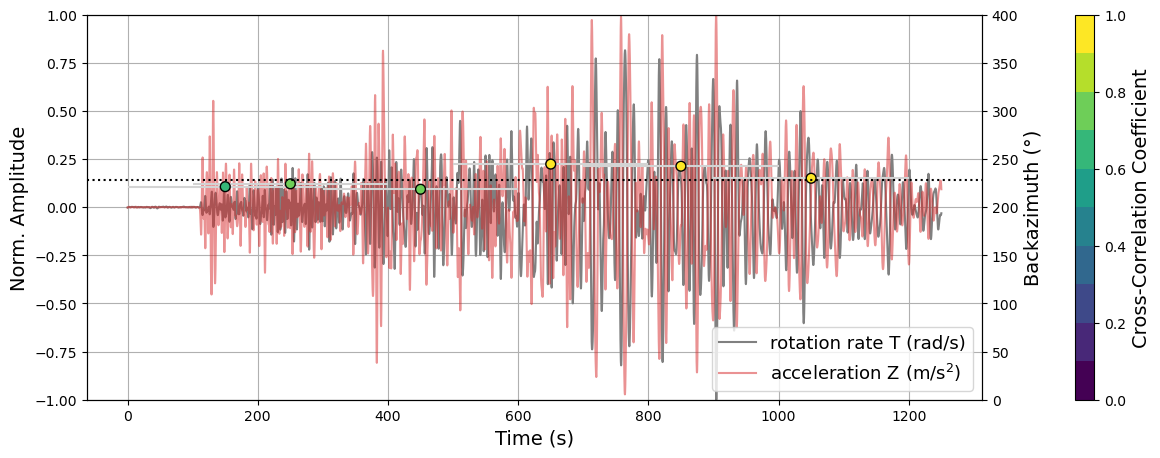

In [132]:
out = __compute_backazimuth_tangent(
                                    rot,
                                    acc,
                                    win_time_s=config['win_length_sec'],
                                    overlap=config['overlap']/100,
                                    baz_theo=baz,
                                    cc_thres=0,
                                    plot=True,
                                    )


out['fig'].savefig(config['path_to_figs']+f"{config['figname']}_baz_tangent_{rot[0].stats.station}{fmin}_{fmax}.png", dpi=150, bbox_inches='tight', pad_inches=0.05)


## Compare Backazimuth Codes

In [275]:
from functions.compare_backazimuth_codes import __compare_backazimuth_codes

In [276]:
out = __compare_backazimuth_codes(rot, acc, event, fmin, fmax, cc_thres=0.1, invert_acc_z=True, plot=True);

# out['fig'].savefig(config['path_to_figs']+f"{config['figname']}_baz_comparison_{rot[0].stats.location}_{fmin}_{fmax}_all.png", dpi=150, bbox_inches='tight', pad_inches=0.05);


TypeError: __compare_backazimuth_codes() got an unexpected keyword argument 'invert_acc_z'

### Wavelet Comparsion

In [130]:
from functions.compute_cwt import __compute_cwt

In [ ]:
component = "Z"

ttt = rot[0].times()
arr = rot.select(channel=f"*{component}")[0].data
dt = rot[0].stats.delta # seconds

out = __compute_cwt(ttt, arr, dt, tscale="min",
                    datalabel=f"BSPF-{component}",
                    period=False,
                    fmax=1,
                    plot=True,
                   )

out['fig'].savefig(config['path_to_figs']+f"{config['figname']}_{component}_cwt.png", format="png", dpi=150, bbox_inches='tight');


In [ ]:
from functions.compute_cross_wavelet_transform import __compute_cross_wavelet_transform

In [ ]:
from obspy.signal.cross_correlation import correlate

In [ ]:
from functions.compute_wavelet_coherencey_transform import __compute_wavelet_coherency_transform

In [ ]:
# out_wct = __compute_wavelet_coherency_transform(
#                                             rot[0].times(),
#                                             rot.select(channel=f"*{comp}")[0].data,
#                                             adr.select(channel=f"*{comp}")[0].data,
#                                             rot[0].stats.delta,
#                                             fmax_limit=config['fmax'],
#                                             normalize=True,
#                                             plot=True,
# )

# out_wct['fig'].savefig(config['path_to_figs']+f"BSPF_M42_wct_{comp}_{config['fmin']}_{config['fmax']}.png", dpi=200, bbox_inches='tight', pad_inches=0.05)


## Coherence in Octaves

In [ ]:
from functions.makeplot_coherence_octaves import __coherence_in_octaves

In [ ]:
def __coherence_in_octaves(st_in, fmin, fmax, normalize=False, plot=True):

    import matplotlib.pyplot as plt

    from matplotlib.gridspec import GridSpec
    from numpy import arange, mean, nan, nanmax, nanmean
    from pandas import DataFrame
    from functions.get_octave_bands import __get_octave_bands
    from scipy.signal import coherence

    flower, fupper, fcenter = __get_octave_bands(fmin, fmax, faction_of_octave=8, plot=False)

    fbands = [(fl, fu) for fl, fu in zip(flower, fupper)]

    colors = {"Z":"tab:red", "N":"tab:green", "E":"blue"}

    ## _____________________

#     ddf = 3
#     fcenter = arange(fmin+ddf, fmax-ddf, 1)
#     fbands = [(fc - ddf, fc + ddf) for fc in fcenter]

    out = {}

    if plot:
        NN = 5
        font = 12
        rot_scale, rot_unit, omega, sqrt_hz = 1e6, r"$\mu$rad/s" , r"$\Omega$", r"$\sqrt{Hz}$"

        fmin_i, fmax_i = 1.0, 6.0 ## 0.16, 16.5
        fmin_a, fmax_a = 0.5, 1.0  ## 0.02, 1.3


        fig = plt.figure(figsize=(15,14))

        gs = GridSpec(NN, 2, figure=fig)

        ax1 = fig.add_subplot(gs[0, :-1])
        ax2 = fig.add_subplot(gs[1, :-1])
        ax3 = fig.add_subplot(gs[2, :-1])

        ax4 = fig.add_subplot(gs[0, 1:])
        ax5 = fig.add_subplot(gs[1, 1:])
        ax6 = fig.add_subplot(gs[2, 1:])

        ax7 = fig.add_subplot(gs[3:, :])

        plt.subplots_adjust(hspace=0.2)



    for ii, comp in enumerate(["Z", "N", "E"]):

        tr0 = st_in.copy().select(station="BSPF", channel=f'*{comp}')[0]
        tr1 = st_in.copy().select(station="BSPF", channel=f'*{comp}')[0]
        tr2 = st_in.copy().select(station="RPFO", location="in", channel=f'*{comp}')[0]
        tr3 = st_in.copy().select(station="RPFO", location="mi", channel=f'*{comp}')[0]

        tr0 = tr0.detrend("linear").taper(0.1).filter("bandpass", freqmin=fmin_i, freqmax=fmax_i, corners=8, zerophase=True)
        tr1 = tr1.detrend("linear").taper(0.1).filter("bandpass", freqmin=fmin_a, freqmax=fmax_a, corners=8, zerophase=True)
        tr2 = tr2.detrend("linear").taper(0.1).filter("bandpass", freqmin=fmin_i, freqmax=fmax_i, corners=8, zerophase=True)
        tr3 = tr3.detrend("linear").taper(0.1).filter("bandpass", freqmin=fmin_a, freqmax=fmax_a, corners=8, zerophase=True)

        if normalize:
            tr0 = tr0.normalize()
            tr1 = tr1.normalize()
            tr2 = tr2.normalize()
            tr3 = tr3.normalize()
            rot_scale, rot_unit = 1, r"rad/s"

        co2, co3 = [], []
        for nn, (fl, fu) in enumerate(fbands):
            s0, s1, s2, s3 = tr0.copy(), tr1.copy(), tr2.copy(), tr3.copy()

            df = s1.stats.sampling_rate

            # tseg = 5/fl
            tseg = 20
            nseg = int(df*tseg) if int(df*tseg) < len(s1.data) else len(s1.data)
            nover = int(0.5*nseg)

            ff2, coh2 = coherence(s0.data, s2.data, fs=df, window='hann', nperseg=nseg, noverlap=nover)
            ff3, coh3 = coherence(s1.data, s3.data, fs=df, window='hann', nperseg=nseg, noverlap=nover)

#             ff2, coh2 = coherence(s1.data, s2.data, fs=df, window='hann')
#             ff3, coh3 = coherence(s1.data, s3.data, fs=df, window='hann')

            for i in range(len(ff2)):
                if ff2[i] <= fl or ff2[i] >= fu:
                    coh2[i], coh3[i] = nan, nan

            plt.semilogx(ff2, coh2)

            # co2.append(nanmax(coh2))
            # co3.append(nanmax(coh3))
            co2.append(nanmean(coh2))
            co3.append(nanmean(coh3))

        if plot:

            if comp == "Z":
                ax1.plot(tr0.times(), tr0.data*rot_scale, color="k", label=f"BSPF-{comp}")
                ax1.plot(tr2.times(), tr2.data*rot_scale, color=colors[comp], label=f"ADR-{comp}")

                ax4.plot(tr1.times(), tr1.data*rot_scale, color="k", label=f"BSPF-{comp}")
                ax4.plot(tr3.times(), tr3.data*rot_scale, color=colors[comp], label=f"ADR-{comp}")

            elif comp == "N":
                ax2.plot(tr0.times(), tr0.data*rot_scale, color="k", label=f"BSPF-{comp}")
                ax2.plot(tr2.times(), tr2.data*rot_scale, color=colors[comp], label=f"ADR-{comp}")

                ax5.plot(tr1.times(), tr1.data*rot_scale, color="k", label=f"BSPF-{comp}")
                ax5.plot(tr3.times(), tr3.data*rot_scale, color=colors[comp], label=f"ADR-{comp}")

            elif comp == "E":
                ax3.plot(tr0.times(), tr0.data*rot_scale, color="k", label=f"BSPF-{comp}")
                ax3.plot(tr2.times(), tr2.data*rot_scale,color=colors[comp], label=f"ADR-{comp}")

                ax6.plot(tr1.times(), tr1.data*rot_scale, color="k", label=f"BSPF-{comp}")
                ax6.plot(tr3.times(), tr3.data*rot_scale, color=colors[comp], label=f"ADR-{comp}")

            for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
                ax.legend(loc=1, ncol=2)
                ax.set_ylabel(f"{omega} ({rot_unit})", fontsize=font)

            ax7.scatter(fcenter, co2, s=40, marker="s", label="BSPF - RPFO_inner", zorder=2, color="w", edgecolors=colors[comp])
            ax7.plot(fcenter, co2, ls="-", color=colors[comp])

            ax7.scatter(fcenter, co3, s=40, label="BSPF - PRFO_mid", zorder=2, color="w", edgecolors=colors[comp])
            ax7.plot(fcenter, co3, ls=":", color=colors[comp])

            ax7.legend(loc=4, ncol=3)

            ax7.set_xscale("log")
            ax7.grid(ls="--", zorder=0, alpha=.5, which="both")

            ax7.set_xlabel("Frequency (Hz)", fontsize=font)
            # ax7.set_ylabel(f"Coherence ({rot_unit}/{sqrt_hz})", fontsize=font)
            ax7.set_ylabel(f"max. coherence per one-third-octave", fontsize=font)

            ax1.set_title(f"PRFO inner ({fmin_i} - {fmax_i} Hz)", fontsize=font)
            ax4.set_title(f"PRFO mid ({fmin_a} - {fmax_a} Hz)", fontsize=font)



        ## prepare output
        out[f'{comp}_in_fc'] = fcenter
        out[f'{comp}_in_co']  = co2
        out[f'{comp}_al_fc'] = fcenter
        out[f'{comp}_al_co']  = co3

    if plot:
        out['fig'] = fig
        plt.show();


    return out

In [ ]:
st = st0.copy();

fmin, fmax = 0.1, 15.0

st.detrend("simple").taper(0.1).filter("bandpass", freqmin=fmin, freqmax=fmax)

# out_coh = __coherence_in_octaves(st, fmin, fmax, normalize=False, plot=True)

# out_coh['fig'].savefig(config['path_to_figs']+f"BSPF_M42_coherence.png", dpi=200, bbox_inches='tight', pad_inches=0.05)

In [ ]:
def __crosscorrelation_in_octaves(st_in, fmin, fmax, normalize=False, plot=True):

    import matplotlib.pyplot as plt

    from matplotlib.gridspec import GridSpec
    from numpy import arange, mean, nan, nanmax
    from pandas import DataFrame
    from functions.get_octave_bands import __get_octave_bands
    from obspy.signal.cross_correlation import correlate

    flower, fupper, fcenter = __get_octave_bands(fmin, fmax, faction_of_octave=6, plot=False)

    fbands = [(fl, fu) for fl, fu in zip(flower, fupper)]

    colors = {"Z":"tab:red", "N":"tab:green", "E":"blue"}

    ## _____________________

    out = {}

    if plot:

        NN = 5
        font = 12
        rot_scale, rot_unit, omega, sqrt_hz = 1e6, r"$\mu$rad/s" , r"$\Omega$", r"$\sqrt{Hz}$"

        fmin_i, fmax_i = 1.0, 6.0 ## 0.16, 16.5
        fmin_a, fmax_a = 0.5, 1.0  ## 0.02, 1.3


        fig = plt.figure(figsize=(15,14))

        gs = GridSpec(NN, 2, figure=fig)

        ax1 = fig.add_subplot(gs[0, :-1])
        ax2 = fig.add_subplot(gs[1, :-1])
        ax3 = fig.add_subplot(gs[2, :-1])

        ax4 = fig.add_subplot(gs[0, 1:])
        ax5 = fig.add_subplot(gs[1, 1:])
        ax6 = fig.add_subplot(gs[2, 1:])

        ax7 = fig.add_subplot(gs[3:, :])

        plt.subplots_adjust(hspace=0.2)



    for ii, comp in enumerate(["Z", "N", "E"]):

        tr0 = st_in.copy().select(station="BSPF", channel=f'*{comp}')[0]
        tr1 = st_in.copy().select(station="BSPF", channel=f'*{comp}')[0]
        tr2 = st_in.copy().select(station="RPFO", location="in", channel=f'*{comp}')[0]
        tr3 = st_in.copy().select(station="RPFO", location="mi", channel=f'*{comp}')[0]

        tr0 = tr0.detrend("linear").taper(0.01).filter("bandpass", freqmin=fmin_i, freqmax=fmax_i, corners=4, zerophase=True)
        tr1 = tr1.detrend("linear").taper(0.01).filter("bandpass", freqmin=fmin_a, freqmax=fmax_a, corners=4, zerophase=True)
        tr2 = tr2.detrend("linear").taper(0.01).filter("bandpass", freqmin=fmin_i, freqmax=fmax_i, corners=4, zerophase=True)
        tr3 = tr3.detrend("linear").taper(0.01).filter("bandpass", freqmin=fmin_a, freqmax=fmax_a, corners=4, zerophase=True)


        cc2, cc3 = [], []
        for nn, (fl, fu) in enumerate(fbands):
            s0, s1, s2, s3 = tr0.copy(), tr1.copy(), tr2.copy(), tr3.copy()

            s0 = s0.detrend("linear").taper(0.01).filter("bandpass", freqmin=fl, freqmax=fu, corners=8, zerophase=True)
            s1 = s1.detrend("linear").taper(0.01).filter("bandpass", freqmin=fl, freqmax=fu, corners=8, zerophase=True)
            s2 = s2.detrend("linear").taper(0.01).filter("bandpass", freqmin=fl, freqmax=fu, corners=8, zerophase=True)
            s3 = s3.detrend("linear").taper(0.01).filter("bandpass", freqmin=fl, freqmax=fu, corners=8, zerophase=True)

            _cc2 = correlate(s0.data, s2.data, 0, demean=True, normalize='naive', method='fft')
            _cc3 = correlate(s1.data, s3.data, 0, demean=True, normalize='naive', method='fft')

            cc2.append(nanmax(_cc2))
            cc3.append(nanmax(_cc3))

        if plot:

            if comp == "Z":
                ax1.plot(tr0.times(), tr0.data*rot_scale, color="k", label=f"BSPF-{comp}")
                ax1.plot(tr2.times(), tr2.data*rot_scale, color=colors[comp], label=f"ADR-{comp}")

                ax4.plot(tr1.times(), tr1.data*rot_scale, color="k", label=f"BSPF-{comp}")
                ax4.plot(tr3.times(), tr3.data*rot_scale, color=colors[comp], label=f"ADR-{comp}")

            elif comp == "N":
                ax2.plot(tr0.times(), tr0.data*rot_scale, color="k", label=f"BSPF-{comp}")
                ax2.plot(tr2.times(), tr2.data*rot_scale, color=colors[comp], label=f"ADR-{comp}")

                ax5.plot(tr1.times(), tr1.data*rot_scale, color="k", label=f"BSPF-{comp}")
                ax5.plot(tr3.times(), tr3.data*rot_scale, color=colors[comp], label=f"ADR-{comp}")

            elif comp == "E":
                ax3.plot(tr0.times(), tr0.data*rot_scale, color="k", label=f"BSPF-{comp}")
                ax3.plot(tr2.times(), tr2.data*rot_scale,color=colors[comp], label=f"ADR-{comp}")

                ax6.plot(tr1.times(), tr1.data*rot_scale, color="k", label=f"BSPF-{comp}")
                ax6.plot(tr3.times(), tr3.data*rot_scale, color=colors[comp], label=f"ADR-{comp}")

            for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
                ax.legend(loc=1, ncol=2)
                ax.set_ylabel(f"{omega} ({rot_unit})", fontsize=font)

            ax7.scatter(fcenter, cc2, s=20, marker="s", label="BSPF - RPFO_inner", zorder=2, color="w", edgecolors=colors[comp])
            ax7.plot(fcenter, cc2, ls="-", color=colors[comp])

            ax7.scatter(fcenter, cc3, s=20, label="BSPF - PRFO_mid", zorder=2, color="w", edgecolors=colors[comp])
            ax7.plot(fcenter, cc3, ls=":", color=colors[comp])

            ax7.legend(loc=3, ncol=3)

            ax7.set_xscale("log")
            ax7.grid(ls="--", zorder=0, alpha=.5, which="both")

            ax7.set_xlabel("Frequency (Hz)", fontsize=font)
            # ax7.set_ylabel(f"Coherence ({rot_unit}/{sqrt_hz})", fontsize=font)
            ax7.set_ylabel(f"max. coherence per one-third-octave", fontsize=font)

            ax1.set_title(f"PRFO inner ({fmin_i} - {fmax_i} Hz)", fontsize=font)
            ax4.set_title(f"PRFO mid ({fmin_a} - {fmax_a} Hz)", fontsize=font)

            ax7.set_ylim(-1, 1)


        ## prepare output
        out[f'{comp}_in_fc'] = fcenter
        out[f'{comp}_in_cc']  = cc2
        out[f'{comp}_al_fc'] = fcenter
        out[f'{comp}_al_cc']  = cc3

    if plot:
        out['fig'] = fig
        plt.show();


    return out

In [ ]:
st = st0.copy();

for tr in st:
    if "BSPF" in tr.stats.station:
        tr.data = np.roll(tr.data, 3)


fmin, fmax = 0.1, 15.0

st.detrend("demean").taper(0.1).filter("bandpass", freqmin=fmin, freqmax=fmax)

# out_coh = __crosscorrelation_in_octaves(st, fmin, fmax, normalize=False, plot=True)

# out_coh['fig'].savefig(config['path_to_figs']+f"BSPF_M42_crosscorrelation_octaves.png", dpi=200, bbox_inches='tight', pad_inches=0.05)


## Compare backazimuth estimate for ADR, BSPF and Beamforming

In [ ]:
from functions.compute_beamforming_pfo import __compute_beamforming_pfo

In [ ]:
# stt = st0.copy();

# acc = stt.copy().select(station="PFO*");

# # for tr in stt:
# #     if "BSPF" in tr.stats.station:
# #         tr.data = np.roll(tr.data, 3)

# cc_thres = 0.1

# ## ____________________
# ## direct rotation
# rot = stt.copy().select(station="BSPF");
# out_bspf_i = __compare_backazimuth_codes(rot, acc, event, 2.0, 5.0, cc_thres=cc_thres, plot=True);
# out_bspf_i['fig3'].savefig(config['path_to_figs']+f"BSPF_M42_baz_comparison_{rot[0].stats.location}_2.0_5.0_all.png", dpi=200, bbox_inches='tight', pad_inches=0.05);

# rot = stt.copy().select(station="BSPF");
# out_bspf_m = __compare_backazimuth_codes(rot, acc, event, 0.5, 1.0, cc_thres=cc_thres, plot=True);
# out_bspf_m['fig3'].savefig(config['path_to_figs']+f"BSPF_M42_baz_comparison_{rot[0].stats.location}_0.5_1.0_all.png", dpi=200, bbox_inches='tight', pad_inches=0.05);

# rot = stt.copy().select(station="BSPF");
# out_bspf_a = __compare_backazimuth_codes(rot, acc, event, 0.1, 0.5, cc_thres=cc_thres, plot=True);
# out_bspf_a['fig3'].savefig(config['path_to_figs']+f"BSPF_M42_baz_comparison_{rot[0].stats.location}_0.1_0.5_all.png", dpi=200, bbox_inches='tight', pad_inches=0.05);

# rot = stt.copy().select(station="BSPF");
# out_bspf_o = __compare_backazimuth_codes(rot, acc, event, 0.8, 1.0, cc_thres=cc_thres, plot=True);
# out_bspf_o['fig3'].savefig(config['path_to_figs']+f"BSPF_M42_baz_comparison_{rot[0].stats.location}_0.8_1.0_all.png", dpi=200, bbox_inches='tight', pad_inches=0.05);

# # out = __compare_backazimuth_codes(rot, acc, event, fmin, fmax, cc_thres=0.2, plot=True);


# ## ____________________
# ## adr rotation
# rot = stt.copy().select(station="RPFO", location="in");
# out_adr_i = __compare_backazimuth_codes(rot, acc, event, 2.0, 5.0, cc_thres=cc_thres, plot=False);

# rot = stt.copy().select(station="RPFO", location="mi");
# out_adr_m = __compare_backazimuth_codes(rot, acc, event, 0.5, 1.0, cc_thres=cc_thres, plot=False);

# rot = stt.copy().select(station="RPFO", location="al");
# out_adr_a = __compare_backazimuth_codes(rot, acc, event, 0.1, 0.5, cc_thres=cc_thres, plot=False);

# rot = stt.copy().select(station="RPFO", location="mi");
# out_adr_o = __compare_backazimuth_codes(rot, acc, event, 0.8, 1.0, cc_thres=cc_thres, plot=False);

# ## ____________________
# ## array beamforming
# out_bf_i = __compute_beamforming_pfo(config['tbeg'], config['tend'], fmin=2.0, fmax=5.0, component="Z", submask="inner", plot=False)
# out_bf_m = __compute_beamforming_pfo(config['tbeg'], config['tend'], fmin=0.5, fmax=1.0, component="Z", submask="mid", plot=False)
# out_bf_a = __compute_beamforming_pfo(config['tbeg'], config['tend'], fmin=0.1, fmax=0.5, component="Z", submask="all", plot=False)
# out_bf_o = __compute_beamforming_pfo(config['tbeg'], config['tend'], fmin=0.8, fmax=1.0, component="Z", submask="mid", plot=False)


In [ ]:
def __makeplot_comparison():

    labels = ["iBSPF", "iADR", "iBF", "mBSPF", "mADR", "mBF", "aBSPF", "aADR", "aBF", "BSPF", "ADR", "BF"]

    fig, ax = plt.subplots(1, 1, figsize=(15, 5))

    font = 12

    ax.axhline(out_bspf_i['baz_theo'], color="k", ls="--", label="theo. Baz.")
    ax.fill_between([-0.3, 4.0], out_bspf_i['baz_theo']-10, out_bspf_i['baz_theo']+10, color="grey", alpha=0.5, label="theo. Baz. +- 10°")


    for j, out in enumerate([out_adr_i, out_adr_m, out_adr_a, out_adr_o]):

        ax.errorbar(j-0.02, out['baz_tangent_max'], yerr=out['baz_tangent_std'], color="tab:blue", zorder=2)
        ax.errorbar(j, out['baz_love_max'], yerr=out['baz_love_std'], color="tab:green", zorder=2)
        ax.errorbar(j+0.02, out['baz_rayleigh_max'], yerr=out['baz_rayleigh_std'], color="tab:red", zorder=2)

        ax.scatter(j-0.02, out['baz_tangent_max'], color="tab:blue", zorder=2, label="Co.Var.", edgecolors="k")
        ax.scatter(j, out['baz_love_max'], color="tab:green", zorder=2, label="Love", edgecolors="k")
        ax.scatter(j+0.02, out['baz_rayleigh_max'], color="tab:red", zorder=2, label="Rayleigh", edgecolors="k")

        ## plot only for legend icon

        if j == 0:
            ax.scatter(j+0.4, out_bf_i['baz_bf_max'], color="tab:orange", zorder=2, label="beamforming", edgecolors="k")
            ax.legend(loc=1)


    for j, out in enumerate([out_bspf_i, out_bspf_m, out_bspf_a, out_bspf_o]):

        ax.errorbar(j+0.18, out['baz_tangent_max'], yerr=out['baz_tangent_std'], color="tab:blue", zorder=2)
        ax.errorbar(j+0.2, out['baz_love_max'], yerr=out['baz_love_std'], color="tab:green", zorder=2)
        ax.errorbar(j+0.22, out['baz_rayleigh_max'], yerr=out['baz_rayleigh_std'], color="tab:red", zorder=2)

        ax.scatter(j+0.18, out['baz_tangent_max'], color="tab:blue", zorder=2, label="Co.Var.", edgecolors="k")
        ax.scatter(j+0.2, out['baz_love_max'], color="tab:green", zorder=2, label="Love", edgecolors="k")
        ax.scatter(j+0.22, out['baz_rayleigh_max'], color="tab:red", zorder=2, label="Rayleigh", edgecolors="k")


    for j, out in enumerate([out_bf_i, out_bf_m, out_bf_a, out_bf_o]):

        ax.errorbar(j+0.4, out['baz_bf_max'], yerr=out['baz_bf_std'], color="tab:orange", zorder=2)
        ax.scatter(j+0.4, out['baz_bf_max'], color="tab:orange", zorder=2, label="", edgecolors="k")



    ax.set_xticks([0,0.2,0.4,1,1.2,1.4,2,2.2,2.4,3,3.2,3.4], labels=labels, fontsize=font-1)

    ax.grid(axis="y", ls=":", color="k", alpha=0.5, zorder=0)

    ax.text(0, 360+10, "2.0 - 5.0 Hz", fontsize=font-1)
    ax.text(1, 360+10, "0.5 - 1.0 Hz", fontsize=font-1)
    ax.text(2, 360+10, "0.1 - 0.5 Hz", fontsize=font-1)
    ax.text(3, 360+10, "0.8 - 1.0 Hz", fontsize=font-1)


    ax.set_ylabel("Backazimuth (°)", fontsize=font)

    ax.set_xlim(-0.3, 4.0)
    ax.set_ylim(0, 360)

    plt.show();
    return fig

In [ ]:
fig = __makeplot_comparison()

fig.savefig(config['path_to_figs']+f"BSPF_M42_baz_comparison_overview.png", dpi=200, bbox_inches='tight', pad_inches=0.05);

## Cross Spectral Density

In [ ]:
from functions.makeplotStream_csd import __makeplotStream_csd

In [ ]:
# fig = __makeplotStream_csd(st0, config);

In [ ]:
def __makeplotStream_coherence(sti, config):

    from scipy import fftpack
    from matplotlib.gridspec import GridSpec
    from scipy.signal import coherence
    from numpy import array, log10

    import matplotlib.pyplot as plt

    st = sti.copy()

    NN = 5
    rot_scaling, rot_unit = 1e6, r"$\mu$rad/s"
    trans_scaling, trans_unit = 1e6, r"$\mu$m/s"

#     rot_scaling, rot_unit = 1, r"nrad/s"
#     trans_scaling, trans_unit = 1, r"$\mu$m/s"

    colors2 = ['darkred', 'darkgreen', 'magenta', 'tab:green', 'red', 'lightgreen']
#     colors2 = ['crimson', 'darkblue', 'red', '#3776ab', 'magenta', 'indigo']

    fig = plt.figure(figsize=(15, 14))

    gs = GridSpec(NN, 2, figure=fig)

    ax1 = fig.add_subplot(gs[0, :-1])
    ax2 = fig.add_subplot(gs[1, :-1])
    ax3 = fig.add_subplot(gs[2, :-1])

    ax4 = fig.add_subplot(gs[0, 1:])
    ax5 = fig.add_subplot(gs[1, 1:])
    ax6 = fig.add_subplot(gs[2, 1:])

    ax7 = fig.add_subplot(gs[3:, :])


    font = 14

    plt.subplots_adjust(hspace=0.1)

    ## _______________________________________________

#     st.normalize()

    st.sort(keys=['channel'], reverse=True)

    bspf_all_data, bspf_inner_data, adr_all_data, adr_inner_data = [],[],[],[]

    names, ffs, csds, ffs2, csds2 = [], [], [], [], []

    for comp in ["Z", "N", "E"]:

        tmp = st.select(channel=f"*{comp}")
        print(tmp)

        bspf_inner = tmp[0].copy()
        bspf_inner.detrend("linear")
        bspf_inner.taper(0.1)
        bspf_inner.filter("bandpass", freqmin=1, freqmax=6, corners=4, zerophase=True)
        bspf_inner.normalize()

        adr_inner = tmp[1].copy()
        adr_inner.detrend("linear")
        adr_inner.taper(0.1)
        adr_inner.filter("bandpass", freqmin=1, freqmax=6, corners=4, zerophase=True)
        adr_inner.normalize()

        nseg = int(5*tmp[0].stats.sampling_rate)


        ff, Pxy = coherence(
                            bspf_inner.data,
                            adr_inner.data,
                            fs=bspf_inner.stats.sampling_rate,
                            nperseg=nseg,
                            window='hann',
                            noverlap=int(0.5*nseg),
                            nfft=None,
                            detrend='constant',
                            axis=-1,
                        )

        names.append(f"{tmp[0].stats.channel}"+r"$_{inner}$")
        ffs.append(ff)
        csds.append(Pxy)

        adr_inner_data.append(adr_inner.data)
        bspf_inner_data.append(bspf_inner.data)

        ## _____________________________________

        bspf_all = tmp[0].copy()
        bspf_all.detrend("linear")
        bspf_all.taper(0.1)
        bspf_all.filter("bandpass", freqmin=0.5, freqmax=1.0, corners=4, zerophase=True)
        bspf_all.normalize()

        adr_all = tmp[2].copy()
        adr_all.detrend("linear")
        adr_all.taper(0.1)
        adr_all.filter("bandpass", freqmin=0.5, freqmax=1.0, corners=4, zerophase=True)
        adr_all.normalize()

        nseg = int(20*tmp[0].stats.sampling_rate)

        ff2, Pxy2 = coherence(
                            bspf_all.data*rot_scaling,
                            adr_all.data*rot_scaling,
                            fs=bspf_all.stats.sampling_rate,
                            nperseg=nseg,
                            window='hann',
                            noverlap=int(0.5*nseg),
                            nfft=None,
                            detrend='constant',
                            axis=-1,
                        )

        names.append(f"{tmp[0].stats.channel}"+r"$_{all}$")

        ffs.append(ff2)
        csds.append(Pxy2)

        adr_all_data.append(adr_all.data)
        bspf_all_data.append(bspf_all.data)

    hz = st.select(channel="B*Z")[0]
    hn = st.select(channel="B*N")[0]
    he = st.select(channel="B*E")[0]

    jz = st.select(channel="HJZ")[0]
    jn = st.select(channel="HJN")[0]
    je = st.select(channel="HJE")[0]

    ax1.plot(hz.times(), bspf_all_data[0], 'black', label=f"BSPF.Z")
    ax2.plot(hn.times(), bspf_all_data[1], 'black', label=f"BSPF.N")
    ax3.plot(he.times(), bspf_all_data[2], 'black', label=f"BSPF.E")
    ax1.plot(hz.times(), adr_all_data[0], 'darkred', label=r"ADR$_{all}$.Z")
    ax2.plot(hn.times(), adr_all_data[1], 'darkred', label=r"ADR$_{all}$.N")
    ax3.plot(he.times(), adr_all_data[2], 'darkred', label=r"ADR$_{all}$.E")

    ax4.plot(jz.times(), bspf_inner_data[0], 'black', label=f"BSPF.Z")
    ax5.plot(jn.times(), bspf_inner_data[1], 'black', label=f"BSPF.N")
    ax6.plot(je.times(), bspf_inner_data[2], 'black', label=f"BSPF.E")
    ax4.plot(jz.times(), adr_inner_data[0], 'darkred', label=r"ADR$_{inner}$.Z")
    ax5.plot(jn.times(), adr_inner_data[1], 'darkred', label=r"ADR$_{inner}$.N")
    ax6.plot(je.times(), adr_inner_data[2], 'darkred', label=r"ADR$_{inner}$.E")


    for ii, (ff, cc, name) in enumerate(zip(ffs, csds, names)):
#         ax7.plot(ff, 20*log10(abs(cc)), label=name[2:], alpha=0.6, color=colors2[ii])
        if "all" in name:
            ax7.plot(ff, abs(cc), label=name[2:], alpha=0.6, color=colors2[ii])
        elif "inner" in name:
            if "Z" in name:
                ax8 = ax7.twinx()
            ax8.plot(ff, abs(cc), label=name[2:], alpha=0.6, color=colors2[ii])


#     ax7.set_yscale("log")

    for ax in [ax1, ax2, ax3, ax4 ,ax5, ax6]:
        ax.legend(loc=1, fontsize=font-2, bbox_to_anchor=(0.95, 1.10), ncol=2)
        ax.set_ylabel(f"$\omega$ ({rot_unit})", fontsize=font)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        if ax not in [ax3, ax6]:
            ax.set(xticklabels=[])
            ax.tick_params(bottom=False)

    ax7.set_xscale("log")
    ax7.grid(which="both", ls=":", alpha=0.7, color="grey")
    ax7.legend(fontsize=font-2, ncol=3, loc=2)
    ax7.set_xlim(0.3, 10)
    ax7.set_xlabel("Frequency (Hz)", fontsize=font)
    sqrthz=r"$\sqrt{Hz}$"
#     ax7.set_ylabel(f"Cross Spectral Density \n (dB rel. to 1 nrad$^2$/s$^2$/Hz)", fontsize=font)
    ax7.set_ylabel(f"Cross Spectral Density ({rot_unit}/{sqrthz}')", fontsize=font)


    ax8.legend(fontsize=font-2, ncol=3, loc=1)
    ax8.set_ylabel(f"Cross Spectral Density ({rot_unit}/{sqrthz}')", fontsize=font, color="tab:red")
    ax8.tick_params(axis='y', colors='tab:red')

    ax3.set_xlabel("Time (s)", fontsize=font)
    ax6.set_xlabel("Time (s)", fontsize=font)


    bbox = list(ax7.get_position().bounds)
    bbox[3] = .85*bbox[3] # Reduce the height of the axis a bit.
    ax7.set_position(bbox)

    for ax in [ax1, ax2, ax3, ax4 ,ax5, ax6, ax7, ax8]:
        ax.tick_params(axis="y", labelsize=font-2)
        ax.tick_params(axis="x", labelsize=font-2)

#     axes[i,0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
#     axes[i,1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

    return fig

In [ ]:
fig = __makeplotStream_coherence(st0, config);

## Phase Velocity

In [ ]:
from functions.compute_velocity_from_amplitude_ratio import __compute_velocity_from_amplitude_ratio

In [ ]:
from functions.makeplot_velocities import __makeplotStream_velocities

In [ ]:
acc = st0.select(station="DROMY*").copy();
rot = st0.select(station="ROMY").copy();

fmin, fmax = config['fmin'], config['fmax']
fmin, fmax = 0.01, 0.05

rot.detrend("demean").taper(0.1).filter("bandpass", freqmin=fmin, freqmax=fmax, zerophase=True, corners=4);
acc.detrend("demean").taper(0.1).filter("bandpass", freqmin=fmin, freqmax=fmax, zerophase=True, corners=4);


In [ ]:
fig = __makeplotStream_velocities(rot, acc, fmin, fmax, baz,
                                  overlap=0.75, cc_threshold=0.5, twin=1/fmin,
                                  reverse_rotZ=False, reverse_accZ=True,
                                 );

fig.savefig(config['path_to_figs']+f"{config['figname']}_velocities_{rot[0].stats.station}_{fmin}_{fmax}.png", dpi=200, bbox_inches='tight', pad_inches=0.05)


# 

### Velocity in F-Bands

In [ ]:
def __estimate_velocity_in_fbands(st0):

    from functions.get_octave_bands import __get_octave_bands

    flower, fupper, fcenter = __get_octave_bands(0.01, 0.1, faction_of_octave=1, plot=False)

    fbands = [(f1, f2) for f1, f2 in zip(flower, fupper)]


    # fbands = [(0.5,0.7), (0.7,0.9), (0.8,1.0), (1.0,2.0), (1.0,5.0), (3.0,8.0), (5.0,12.0)]

    love_velo, rayl_velo = [], []
    r_flabels, l_flabels = [], []

    velo = np.arange(0, 5000, 250)


    for fmin, fmax in fbands:

        fmin, fmax = round(fmin, 3), round(fmax, 3)

        if fmin == fmax:
            continue

        print(fmin, fmax)

        acc = st0.select(station="DROMY").copy();
        rot = st0.select(station="ROMY").copy();


        rot = rot.detrend("demean").taper(0.1).filter("bandpass", freqmin=fmin, freqmax=fmax, zerophase=True, corners=2);
        acc = acc.detrend("demean").taper(0.1).filter("bandpass", freqmin=fmin, freqmax=fmax, zerophase=True, corners=2);

        cc_threshold = 0.8
        overlap = 0.9
        twin = 1/fmin

        out_l = __compute_velocity_from_amplitude_ratio(
                                                        rot,
                                                        acc,
                                                        baz=baz,
                                                        mode='love',
                                                        win_time_s=twin,
                                                        cc_thres=cc_threshold,
                                                        overlap=overlap,
                                                        flim=(fmin, fmax),
                                                        plot=True,
        )

        lvel = out_l['velocity'][~np.isnan(out_l['velocity'])]

        if len(lvel) > 2 and not np.isnan(lvel).all():
            hist = np.histogram(out_l['velocity'],
                                bins=len(velo)-1,
                                range=[np.nanmin(velo), np.nanmax(velo)],
                                weights=(out_l['ccoef']*100).astype(int),
                                density=False
                               )

            data = np.concatenate([np.ones(int(nnn))*val for nnn, val in zip(hist[0], hist[1])], axis=0 )

            love_velo.append(data)

            l_flabels.append(f"{round(fmin,1)}-{round(fmax,1)}Hz")


        acc.select(channel="*Z")[0].data *= -1

        out_r = __compute_velocity_from_amplitude_ratio(
                                                        rot,
                                                        acc,
                                                        baz=baz,
                                                        mode='rayleigh',
                                                        win_time_s=twin,
                                                        cc_thres=cc_threshold,
                                                        overlap=overlap,
                                                        flim=(fmin, fmax),
                                                        plot=True,
        )

        rvel = out_r['velocity'][~np.isnan(out_r['velocity'])]

        if len(rvel) > 2 and not np.isnan(rvel).all():
            hist = np.histogram(out_r['velocity'],
                                bins=len(velo)-1,
                                range=[np.nanmin(velo), np.nanmax(velo)],
                                weights=(out_r['ccoef']*100).astype(int),
                                density=False,
                               )

            data = np.concatenate([np.ones(int(nnn))*val for nnn, val in zip(hist[0], hist[1])], axis=0 )

            rayl_velo.append(data)

            r_flabels.append(f"{round(fmin,1)}-{round(fmax,1)}Hz")


    #     plt.figure()
    #     plt.hist(out_l['velocity'], bins=len(velo)-1, range=[min(velo), max(velo)], weights=out_l['ccoef'], density=False, rwidth=0.9)
    #     plt.show();

    #     plt.figure()
    #     plt.hist(out_r['velocity'], bins=len(velo)-1, range=[min(velo), max(velo)], weights=out_r['ccoef'], density=False, rwidth=0.9)
    #     plt.show();


    fig1, ax = plt.subplots(1, 1, figsize=(15,5))

    data = love_velo

    ax.yaxis.grid(True)
    ax.violinplot(data, showmeans=False, showmedians=True, showextrema=True)

    ax.set_ylabel("Love Phase Velocity (m/s)")
    ax.set_xticks([y + 1 for y in range(len(data))], labels=l_flabels)

    if rot[0].stats.station == "RPFO":
        ax.set_title(f" {acc[0].stats.station} - {rot[0].stats.station}{rot[0].stats.location[0]} | Overlap = {int(overlap*100)} % | CC_limit = {cc_threshold}")
    else:
        ax.set_title(f" {acc[0].stats.station} - {rot[0].stats.station} | Overlap = {int(overlap*100)} % | CC_limit = {cc_threshold}")


    plt.show();




    fig2, ax = plt.subplots(1, 1, figsize=(15,5))

    data = rayl_velo
    print(data)

    ax.yaxis.grid(True)
    out2 = ax.violinplot(data, showmeans=False, showmedians=True, showextrema=True)

    ax.set_ylabel("Rayleigh Phase Velocity (m/s)")
    ax.set_xticks([y + 1 for y in range(len(data))], labels=r_flabels)

    if rot[0].stats.station == "RPFO":
        ax.set_title(f" {acc[0].stats.station} - {rot[0].stats.station}{rot[0].stats.location[0]} | Overlap = {int(overlap*100)} % | CC_limit = {cc_threshold}")
    else:
        ax.set_title(f" {acc[0].stats.station} - {rot[0].stats.station} | Overlap = {int(overlap*100)} % | CC_limit = {cc_threshold}")

    plt.show();
    return fig1, fig2

In [ ]:
st = st0.copy()

fig1, fig2 = __estimate_velocity_in_fbands(st)


fig1.savefig(config['path_to_figs']+f"BSFP_M42_Love_velocity_fbands_{rot[0].stats.station}.png", format="png", dpi=200, bbox_inches='tight')

fig2.savefig(config['path_to_figs']+f"BSFP_M42_Rayleigh_velocity_fbands_{rot[0].stats.station}_{rot[0].stats.location}.png", format="png", dpi=200, bbox_inches='tight')